In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os

#tensorflow
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model


In [2]:
#get the images directory
image_dir = os.getcwd() + '\\images\\finding_waldo'

#get the background and waldo image directory
background_dir = image_dir + '\\wheres_wally.jpg'
waldo_dir = image_dir + '\\waldo.png'
wilma_dir = image_dir + '\\wilma.png'

In [3]:
#create a function to generate images
def generate_sample_image():
    
    #background image
    background_im = Image.open(background_dir)
    background_im = background_im.resize((500, 350))

    #waldo
    waldo_im = Image.open(waldo_dir)
    waldo_im = waldo_im.resize((60, 100))

    #wilma
    wilma_im = Image.open(wilma_dir)
    wilma_im = wilma_im.resize((60, 100))
    
    #select x and y coordinates randomly we'll select between (0, 430) and (0, 250)
    col = np.random.randint(0, 410)
    row = np.random.randint(0, 230)
    
    #pic randomly between waldo and wilma. If 1 we will select waldo. if 0 we wills elect wilma
    rand_person = np.random.choice([0, 1], p = [0.5, 0.5])
    
    if rand_person == 1:
        
        background_im.paste(waldo_im, (col, row), mask = waldo_im)
        cat = 'Waldo'
        
    else:
        
        background_im.paste(wilma_im, (col, row), mask = wilma_im)
        cat = 'Wilma'
        
    return np.array(background_im).astype('uint8'), (col, row), rand_person, cat 

In [4]:
def plot_bounding_box(image, gt_coords, pred_coords = None):
    
    #convert image to array
    image = Image.fromarray(image)    
    draw = ImageDraw.Draw(image)
    draw.rectangle((gt_coords[0], gt_coords[1], gt_coords[0] + 60, gt_coords[1] + 100), outline = 'green', width = 5)
    
    if pred_coords:
        
        draw.rectangle((pred_coords[0], pred_coords[1], pred_coords[0] + 60, pred_coords[1] + 100), outline = 'red', width = 5)
    
    return image

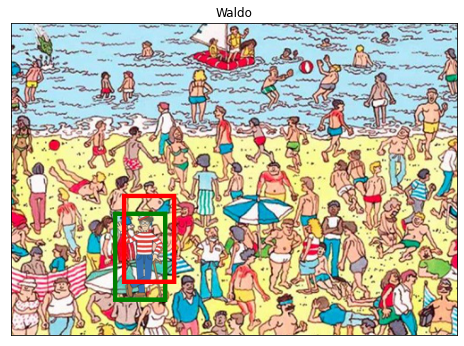

In [5]:
#generate an example image
sample_im, pos, _, cat = generate_sample_image()

#get image with bounding box
im = plot_bounding_box(sample_im, pos, (pos[0] + 10, pos[1] -20))

plt.figure(figsize = (8, 8))
plt.imshow(im)
plt.title(cat)
plt.xticks([])
plt.yticks([])
plt.show()


In [6]:
sample_im.shape

(350, 500, 3)

In [7]:
#data generator function 

def generate_data(batch_size = 16):
    
    while True:
        
        #create empty arrays for the generated data
        x_batch = np.zeros((batch_size, 350, 500, 3))
        y_batch = np.zeros((batch_size, 1))
        boundary_box = np.zeros((batch_size, 2))
        
        for i in range(batch_size):
            
            #generate an example image
            sample_im, pos, person, _ = generate_sample_image()
            
            #put the images to the arrays
            x_batch[i] = sample_im/255 #normalize
            y_batch[i] = person
            boundary_box[i, 0] = pos[0]
            boundary_box[i, 1] = pos[1]
            
        yield {'image': x_batch} , {'class': y_batch, 'box': boundary_box}      

In [42]:
#create a custom callback to plot the figures after certain epochs

def test_model():
    
    #create sample image
    #generate an example image
    sample_im, pos, _, cat = generate_sample_image()
    
    sample_image_normalized = sample_im.reshape(1, 350, 500, 3)/255
    
    predicted_class, predicted_box = model.predict(sample_image_normalized)
        
    #get image with bounding box
    im = plot_bounding_box(sample_im, pos, (predicted_box[0][0], predicted_box[0][1]))

    plt.figure(figsize = (8, 8))
    plt.imshow(im)
    plt.title(cat)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    

class VisCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None):
        
        test_model()

In [43]:
#create the model
def convolutional_block(inputs):
    
    x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs)
    x = tf.keras.layers.MaxPool2D(pool_size = (5, 5), strides = 5)(x)
    
    x = tf.keras.layers.Conv2D(32, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (10, 10), strides = 5)(x)
    
    
    return x

def regression_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, name = 'box')(x)
    
    return x

def classification_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'class')(x)
    
    return x

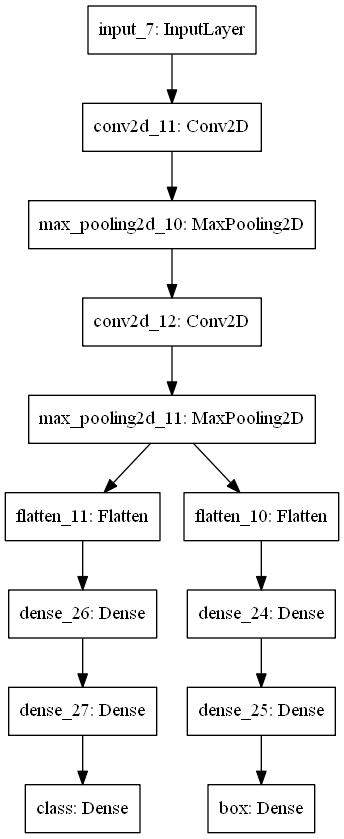

In [44]:
inputs = tf.keras.Input((350, 500, 3))

x = convolutional_block(inputs)

box_output = regression_block(x)
class_output = classification_block(x)

model = tf.keras.Model(inputs = inputs, outputs = [class_output, box_output])
plot_model(model)

In [45]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'class': 'binary_crossentropy', 'box': 'mse'}, \
              metrics = {'class': 'accuracy','box': 'mse'})

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 20002.6250 - class_loss: 2.1546 - box_loss: 20000.4727 - class_accuracy: 0.4875 - box_mse: 20000.4727

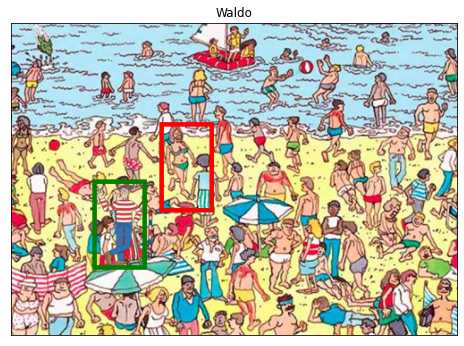

10/10 [==============================] - 16s 2s/step - loss: 20002.6250 - class_loss: 2.1546 - box_loss: 20000.4727 - class_accuracy: 0.4875 - box_mse: 20000.4727
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 10560.2588 - class_loss: 1.0785 - box_loss: 10559.1807 - class_accuracy: 0.4313 - box_mse: 10559.1807

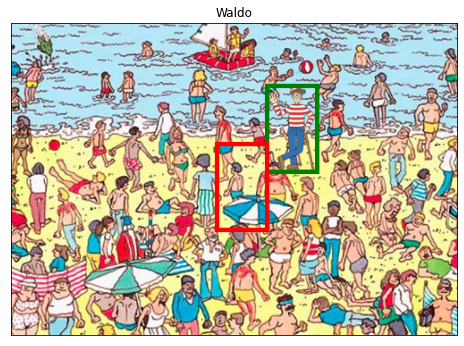

10/10 [==============================] - 15s 2s/step - loss: 10560.2588 - class_loss: 1.0785 - box_loss: 10559.1807 - class_accuracy: 0.4313 - box_mse: 10559.1807
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 9538.5332 - class_loss: 0.7504 - box_loss: 9537.7822 - class_accuracy: 0.5500 - box_mse: 9537.7822

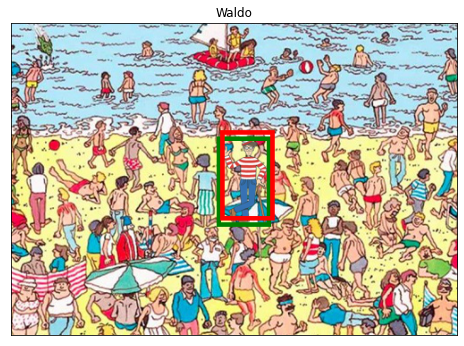

10/10 [==============================] - 16s 2s/step - loss: 9538.5332 - class_loss: 0.7504 - box_loss: 9537.7822 - class_accuracy: 0.5500 - box_mse: 9537.7822
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 9922.1885 - class_loss: 0.7177 - box_loss: 9921.4707 - class_accuracy: 0.4938 - box_mse: 9921.4707 

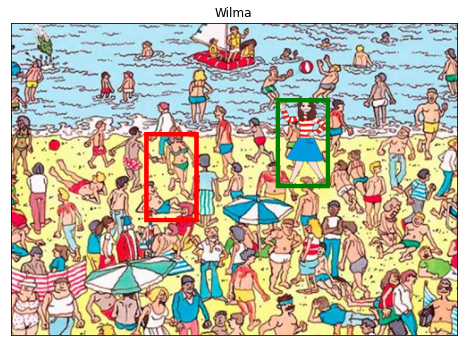

10/10 [==============================] - 16s 2s/step - loss: 9922.1885 - class_loss: 0.7177 - box_loss: 9921.4707 - class_accuracy: 0.4938 - box_mse: 9921.4707
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 11102.1172 - class_loss: 0.7583 - box_loss: 11101.3594 - class_accuracy: 0.5375 - box_mse: 11101.3594

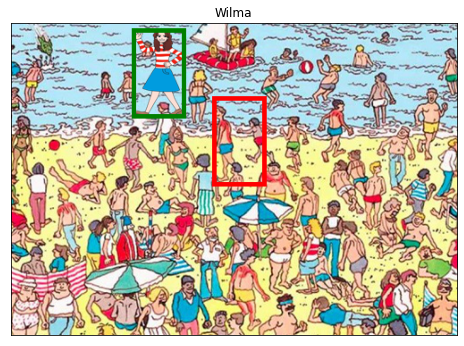

10/10 [==============================] - 16s 2s/step - loss: 11102.1172 - class_loss: 0.7583 - box_loss: 11101.3594 - class_accuracy: 0.5375 - box_mse: 11101.3594
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 9677.8955 - class_loss: 0.7727 - box_loss: 9677.1221 - class_accuracy: 0.5000 - box_mse: 9677.1221

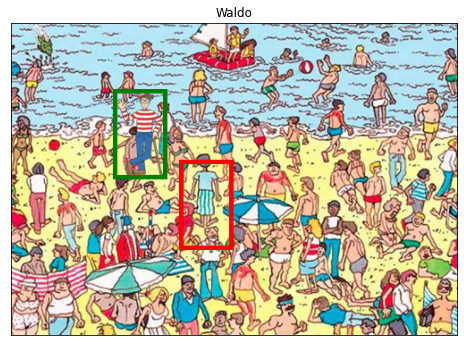

10/10 [==============================] - 16s 2s/step - loss: 9677.8955 - class_loss: 0.7727 - box_loss: 9677.1221 - class_accuracy: 0.5000 - box_mse: 9677.1221
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 9472.1504 - class_loss: 0.7168 - box_loss: 9471.4326 - class_accuracy: 0.4938 - box_mse: 9471.4326

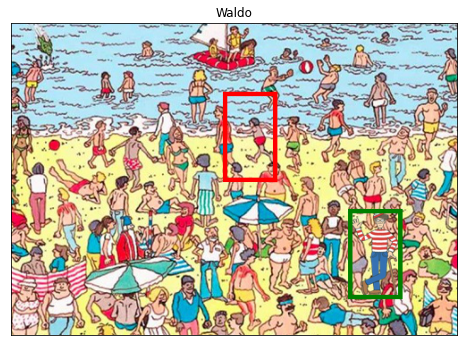

10/10 [==============================] - 16s 2s/step - loss: 9472.1504 - class_loss: 0.7168 - box_loss: 9471.4326 - class_accuracy: 0.4938 - box_mse: 9471.4326
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 9806.3105 - class_loss: 0.7051 - box_loss: 9805.6064 - class_accuracy: 0.5688 - box_mse: 9805.6064 

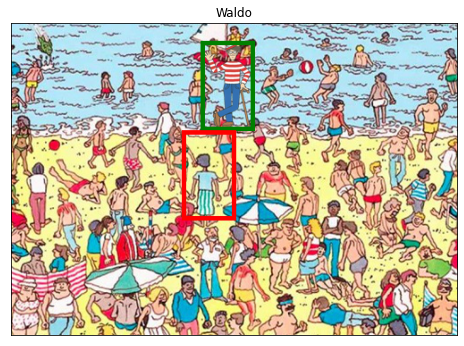

10/10 [==============================] - 15s 2s/step - loss: 9806.3105 - class_loss: 0.7051 - box_loss: 9805.6064 - class_accuracy: 0.5688 - box_mse: 9805.6064
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 10343.6777 - class_loss: 0.7058 - box_loss: 10342.9717 - class_accuracy: 0.4750 - box_mse: 10342.9717

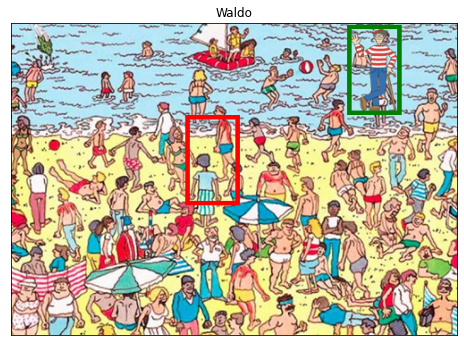

10/10 [==============================] - 16s 2s/step - loss: 10343.6777 - class_loss: 0.7058 - box_loss: 10342.9717 - class_accuracy: 0.4750 - box_mse: 10342.9717
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 10162.8223 - class_loss: 0.6944 - box_loss: 10162.1289 - class_accuracy: 0.5063 - box_mse: 10162.1289

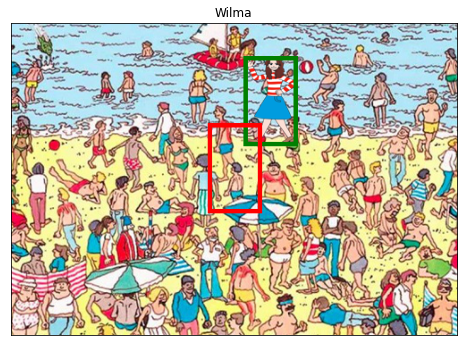

10/10 [==============================] - 16s 2s/step - loss: 10162.8223 - class_loss: 0.6944 - box_loss: 10162.1289 - class_accuracy: 0.5063 - box_mse: 10162.1289


In [46]:
model.fit(generate_data(), epochs = 10, steps_per_epoch = 10, callbacks = [VisCallback()])

In [13]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 350, 500, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 350, 500, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 70, 100, 16)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 65, 95, 32)   18464       max_pooling2d[0][0]              
_______________________________________________________________________________________